In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Kaggle API


In [ ]:
#!rm -r /root/.kaggle

In [ ]:
#! mkdir ~/.kaggle

In [ ]:
#! cp kaggle.json ~/.kaggle

In [ ]:
#! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#! kaggle datasets download -d jangedoo/utkface-new

In [ ]:
#! unzip utkface-new.zip

In [ ]:
#! kaggle datasets list

# GPU

In [2]:
import tensorflow as tf

In [3]:
device_list = tf.test.gpu_device_name()

device_list

'/device:GPU:0'

In [4]:
!nvidia-smi

Wed May 10 22:31:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    55W / 400W |    691MiB / 40960MiB |      6%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Packages

In [1]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd 
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import os
import cv2
from sklearn.svm import SVC
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skimage.color import rgb2gray
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16
from skimage.feature import hog
from skimage import data, exposure
import random
from keras import layers, losses
from keras.models import Model
from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import math
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

# Functions

In [5]:
def display(img):
    plt.imshow(img)
    plt.show()


def prediction_metrics_age(model, X_test, y_test, classes):
    preds = []
    truth = []
    y_hat = model.predict(X_test)

    for i in range(X_test.shape[0]):
        
        predict_index = np.argmax(y_hat[i])
        preds.append(predict_index) 
        
        true_index = np.argmax(y_test[i])
        truth.append(true_index)
        
    mcc = matthews_corrcoef(truth, preds)
    print("MCC: ", mcc)
    label = list(set(classes))
    cm = confusion_matrix(truth, preds)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=label, yticklabels=label)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(truth, preds))


def prediction_metrics_gender(model, X_test, y_test, classes):
  y_hat = model.predict(X_test)
  y_hat = np.round(y_hat)   

  mcc = matthews_corrcoef(y_test, y_hat)
  print("MCC: ", mcc)
  label = list(set(classes))
  cm = confusion_matrix(y_test, y_hat)
  sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=label, yticklabels=label)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()
  print(classification_report(y_test, y_hat))
  
def loss_plot(history, fig_width=12, fig_height=6):
    # Create a new figure with the specified width and height
    plt.figure(figsize=(fig_width, fig_height))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Load Balanced Data

In [2]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/new_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/new_data')


## Age Classes

In [16]:
#age_classes_vars = np.load('../../../data_project/new_data/age_classes_vars.npz')
age_classes_vars = np.load('/content/drive/MyDrive/new_data/content/new_data/age_classes_vars.npz')

X_age_classes = age_classes_vars['x']
y_age_classes = age_classes_vars['y']

print(X_age_classes.shape)
print(len(y_age_classes))

(3480, 200, 200, 3)
3480


In [17]:
age_categories = to_categorical(y_age_classes, num_classes=6)

## Genders

In [6]:
gender_vars = np.load('/content/drive/MyDrive/new_data/content/new_data/gender_vars.npz')
#gender_vars = np.load('../../../data_project/new_data/gender_vars.npz')

X_genders = gender_vars['x']
y_genders = gender_vars['y']

print(X_genders.shape)
print(len(y_genders))

(20000, 200, 200, 3)
20000


In [ ]:
perm = np.random.permutation(len(X_genders))
X_genders = X_genders[perm]
y_genders = y_genders[perm]

#use only a portion of the shuffled arrays for the train-test split
X_genders = X_genders[:10000]
y_genders = y_genders[:10000]

# MODELS

## BASE

In [ ]:
def CNN (input_shape, output, activation):
    
    model = tf.keras.Sequential()

    
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape = input_shape)) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
 

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))


    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(output, activation=activation))
    
    model.summary()
    
    return model

#otimizar 2k
#adicionar mais conv?
#Dropout antes do flaten apenas
#Mexer otimizador (lr)
#implementar early stoping (). Early Stoping tem patience: e.g., 10 epcohs, ele espera 10 epochs antes de parar.
#ir gravando cnn no servidor

### Gender

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_genders, y_genders, test_size=0.2, random_state=42)


X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [ ]:
model = CNN((200,200,3), 1, 'sigmoid')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 64)       0

In [ ]:
#for age use categorical_crossentropy instead
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

history_base_gender = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/20
250/250 [==============================] - 19s 23ms/step - loss: 0.5724 - accuracy: 0.7042 - val_loss: 0.3970 - val_accuracy: 0.8340
Epoch 2/20
250/250 [==============================] - 3s 11ms/step - loss: 0.3998 - accuracy: 0.8223 - val_loss: 0.3243 - val_accuracy: 0.8610
Epoch 3/20
250/250 [==============================] - 3s 11ms/step - loss: 0.3709 - accuracy: 0.8389 - val_loss: 0.3072 - val_accuracy: 0.8665
Epoch 4/20
250/250 [==============================] - 3s 10ms/step - loss: 0.3238 - accuracy: 0.8591 - val_loss: 0.2880 - val_accuracy: 0.8670
Epoch 5/20
250/250 [==============================] - 3s 11ms/step - loss: 0.2982 - accuracy: 0.8706 - val_loss: 0.2892 - val_accuracy: 0.8640
Epoch 6/20
250/250 [==============================] - 3s 10ms/step - loss: 0.2783 - accuracy: 0.8839 - val_loss: 0.2783 - val_accuracy: 0.8900
Epoch 7/20
250/250 [==============================] - 3s 10ms/step - loss: 0.2586 - accuracy: 0.8860 - val_loss: 0.2661 - val_accuracy: 0.887

63/63 [==============================] - 0s 6ms/step
MCC:  0.7891202588979064


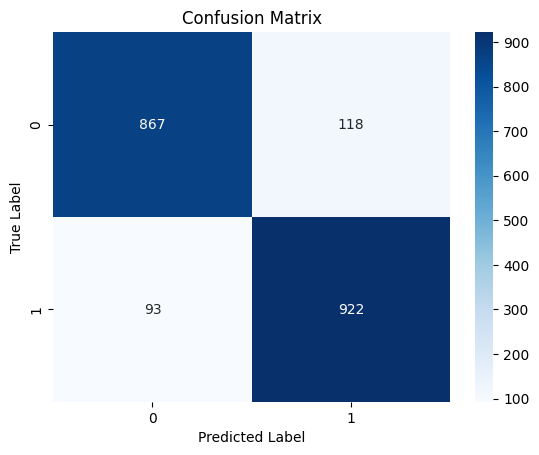

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       985
           1       0.89      0.91      0.90      1015

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [ ]:
prediction_metrics_gender(model, X_test, y_test, y_genders)

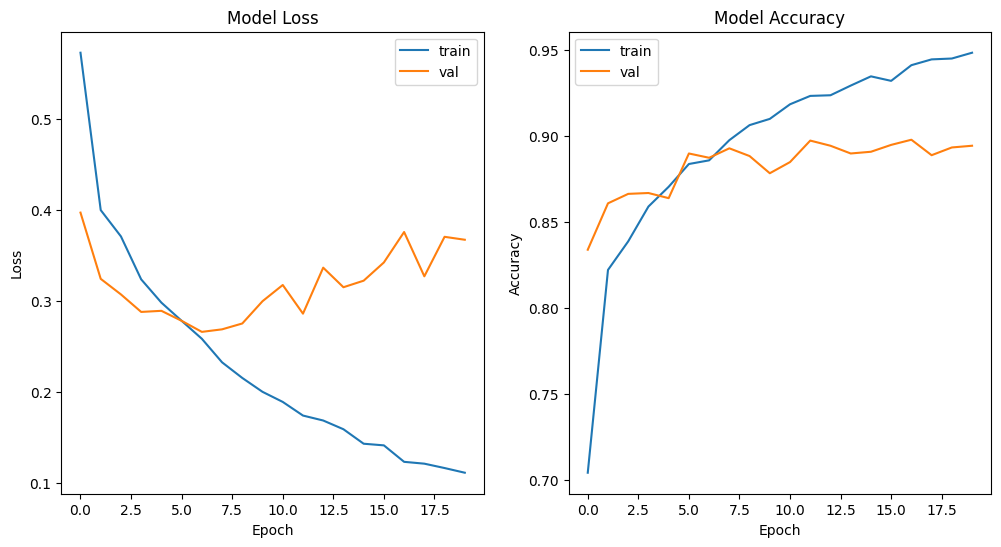

In [ ]:
loss_plot (history_base_gender)

### Age

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_age_classes, age_categories, test_size = 0.2, shuffle = True)

In [ ]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [ ]:
model = CNN((200,200,3), 6, 'softmax')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 25, 25, 64)      

In [ ]:
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_base_age = model.fit(X_train, y_train,
        batch_size=32,
        epochs=20,
        validation_data=(X_test, y_test),)

Epoch 1/20
87/87 [==============================] - 4s 18ms/step - loss: 1.7836 - accuracy: 0.1990 - val_loss: 1.6778 - val_accuracy: 0.2658
Epoch 2/20
87/87 [==============================] - 1s 11ms/step - loss: 1.5963 - accuracy: 0.2906 - val_loss: 1.3661 - val_accuracy: 0.4023
Epoch 3/20
87/87 [==============================] - 1s 11ms/step - loss: 1.4695 - accuracy: 0.3509 - val_loss: 1.3523 - val_accuracy: 0.4784
Epoch 4/20
87/87 [==============================] - 1s 11ms/step - loss: 1.4182 - accuracy: 0.3689 - val_loss: 1.2578 - val_accuracy: 0.4698
Epoch 5/20
87/87 [==============================] - 1s 11ms/step - loss: 1.3614 - accuracy: 0.4005 - val_loss: 1.2023 - val_accuracy: 0.5129
Epoch 6/20
87/87 [==============================] - 1s 11ms/step - loss: 1.2920 - accuracy: 0.4274 - val_loss: 1.2206 - val_accuracy: 0.4727
Epoch 7/20
87/87 [==============================] - 1s 11ms/step - loss: 1.2925 - accuracy: 0.4098 - val_loss: 1.1205 - val_accuracy: 0.5489
Epoch 8/20
87

22/22 [==============================] - 0s 6ms/step
MCC:  0.5159706928112787


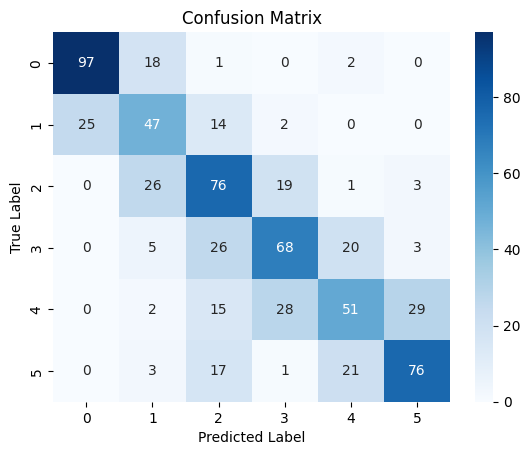

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       118
           1       0.47      0.53      0.50        88
           2       0.51      0.61      0.55       125
           3       0.58      0.56      0.57       122
           4       0.54      0.41      0.46       125
           5       0.68      0.64      0.66       118

    accuracy                           0.60       696
   macro avg       0.59      0.60      0.59       696
weighted avg       0.60      0.60      0.59       696



In [ ]:
prediction_metrics_age(model, X_test, y_test, y_age_classes)

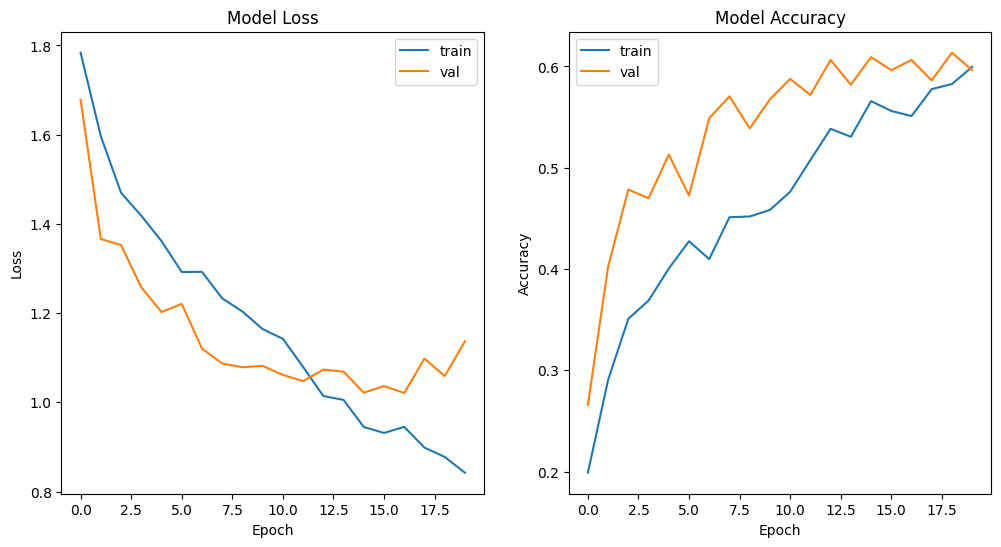

In [ ]:
loss_plot (history_base_age)

## HOG

### Gender

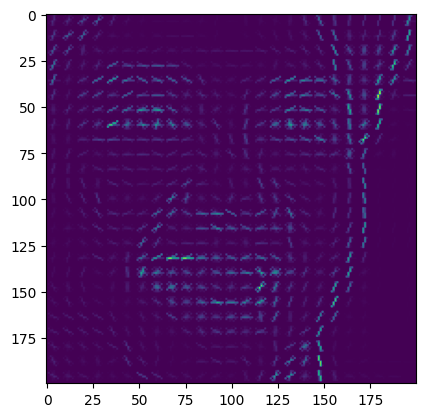

In [ ]:
image_check = X_genders[25]

# define HOG parameters
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

# compute HOG features and visualize them
hog_features, hog_image = hog(image_check, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, visualize=True,channel_axis=2)



# rescale image intensity for better visualization
#hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# display HOG features
plt.imshow(hog_image)
plt.show()

In [ ]:
hog_features = []
for img in X_genders:
    hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, channel_axis=2)
    
    hog_features.append(hog_feature)
hog_features = np.array(hog_features)

In [ ]:
cnn = Sequential()

#tratado
cnn.add(layers.Reshape((144, 144, 1), input_shape=(20736,)))
#cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=X_train[1].shape))


cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(Flatten())

cnn.add(Dense(64, activation='relu'))

cnn.add(layers.Dropout(0.5))

#output layer with 2 filters for number of classes the model will choose to do predictions
#and since gender is just binary classification sigmoid is appropriate
#when doing classification for age (wont be binary classification) then softmax is good choice
cnn.add(Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 144, 144, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 144, 144, 16)      160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 72, 72, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 36, 36, 64)       

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(hog_features, y_genders, test_size=0.2, random_state=42)

In [ ]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [ ]:
cnn.compile(optimizer="adam", loss="binary_crossentropy",
            metrics=['accuracy'])

history_hog_gender = cnn.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/20
250/250 [==============================] - 4s 7ms/step - loss: 0.6946 - accuracy: 0.5010 - val_loss: 0.6920 - val_accuracy: 0.5075
Epoch 2/20
250/250 [==============================] - 1s 5ms/step - loss: 0.6351 - accuracy: 0.6334 - val_loss: 0.5057 - val_accuracy: 0.7635
Epoch 3/20
250/250 [==============================] - 1s 5ms/step - loss: 0.4790 - accuracy: 0.7736 - val_loss: 0.3921 - val_accuracy: 0.8155
Epoch 4/20
250/250 [==============================] - 1s 5ms/step - loss: 0.4049 - accuracy: 0.8196 - val_loss: 0.3467 - val_accuracy: 0.8405
Epoch 5/20
250/250 [==============================] - 1s 5ms/step - loss: 0.3638 - accuracy: 0.8381 - val_loss: 0.3414 - val_accuracy: 0.8395
Epoch 6/20
250/250 [==============================] - 1s 5ms/step - loss: 0.3339 - accuracy: 0.8516 - val_loss: 0.3390 - val_accuracy: 0.8415
Epoch 7/20
250/250 [==============================] - 1s 5ms/step - loss: 0.2990 - accuracy: 0.8695 - val_loss: 0.3329 - val_accuracy: 0.8495
Epoch 

63/63 [==============================] - 0s 2ms/step
MCC:  0.7076504024422744


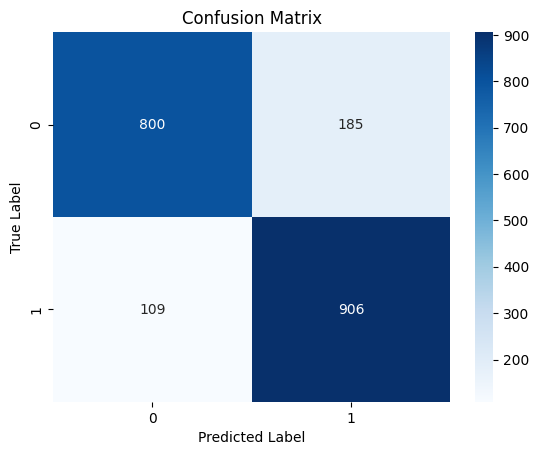

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       985
           1       0.83      0.89      0.86      1015

    accuracy                           0.85      2000
   macro avg       0.86      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



In [ ]:
prediction_metrics_gender(cnn, X_test, y_test, y_genders)

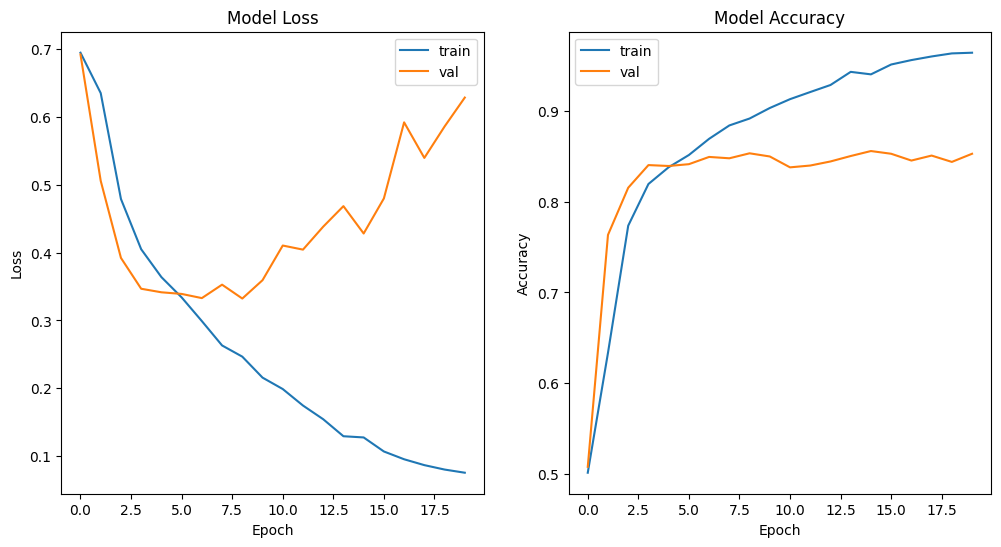

In [ ]:
loss_plot (history_hog_gender)

### Age

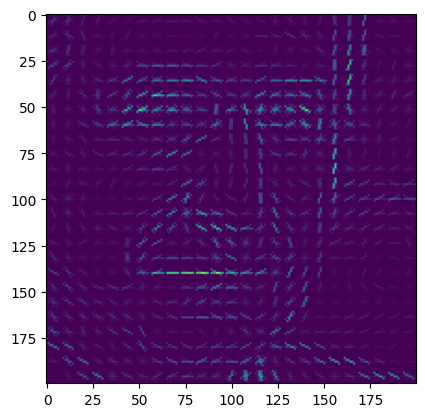

In [ ]:
image_check = X_age_classes[25]

# define HOG parameters
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

# compute HOG features and visualize them
hog_features, hog_image = hog(image_check, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, visualize=True,channel_axis=2)



# rescale image intensity for better visualization
#hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# display HOG features
plt.imshow(hog_image)
plt.show()

In [ ]:
hog_features = []
for img in X_age_classes:

    hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, channel_axis=2)
    
    hog_features.append(hog_feature)
hog_features = np.array(hog_features)

In [ ]:
cnn = Sequential()

cnn.add(layers.Reshape((144, 144, 1), input_shape=(20736,)))
#cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=X_train[1].shape))

cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))

cnn.add(layers.MaxPooling2D(2,2))
cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(Flatten())

cnn.add(Dense(64, activation='relu'))

cnn.add(layers.Dropout(0.2))

#output layer with 2 filters for number of classes the model will choose to do predictions
#and since gender is just binary classification sigmoid is appropriate
#when doing classification for age (wont be binary classification) then softmax is good choice
cnn.add(Dense(6, activation='softmax'))

cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 144, 144, 1)       0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 72, 72, 1)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 36, 36, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 18, 18, 64)      

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(hog_features, age_categories, test_size = 0.2,shuffle = True)

In [ ]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [ ]:
cnn.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_hog_age = cnn.fit(X_train, y_train,
        batch_size=32,
        epochs=20,
        validation_data=(X_test, y_test),)

Epoch 1/20
87/87 [==============================] - 2s 8ms/step - loss: 1.7940 - accuracy: 0.1728 - val_loss: 1.7869 - val_accuracy: 0.2241
Epoch 2/20
87/87 [==============================] - 0s 5ms/step - loss: 1.7439 - accuracy: 0.2568 - val_loss: 1.6912 - val_accuracy: 0.3204
Epoch 3/20
87/87 [==============================] - 0s 5ms/step - loss: 1.6066 - accuracy: 0.3384 - val_loss: 1.5566 - val_accuracy: 0.3879
Epoch 4/20
87/87 [==============================] - 0s 5ms/step - loss: 1.4967 - accuracy: 0.3743 - val_loss: 1.4505 - val_accuracy: 0.3851
Epoch 5/20
87/87 [==============================] - 0s 5ms/step - loss: 1.4063 - accuracy: 0.4037 - val_loss: 1.3449 - val_accuracy: 0.4425
Epoch 6/20
87/87 [==============================] - 0s 5ms/step - loss: 1.3272 - accuracy: 0.4540 - val_loss: 1.3290 - val_accuracy: 0.4555
Epoch 7/20
87/87 [==============================] - 0s 5ms/step - loss: 1.2787 - accuracy: 0.4741 - val_loss: 1.2338 - val_accuracy: 0.4856
Epoch 8/20
87/87 [==

22/22 [==============================] - 0s 3ms/step
MCC:  0.42493460396481086


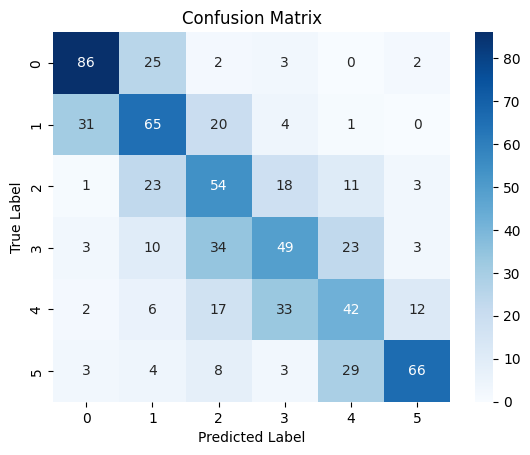

              precision    recall  f1-score   support

           0       0.68      0.73      0.70       118
           1       0.49      0.54      0.51       121
           2       0.40      0.49      0.44       110
           3       0.45      0.40      0.42       122
           4       0.40      0.38      0.39       112
           5       0.77      0.58      0.66       113

    accuracy                           0.52       696
   macro avg       0.53      0.52      0.52       696
weighted avg       0.53      0.52      0.52       696



In [ ]:
prediction_metrics_age(cnn, X_test, y_test, y_age_classes)

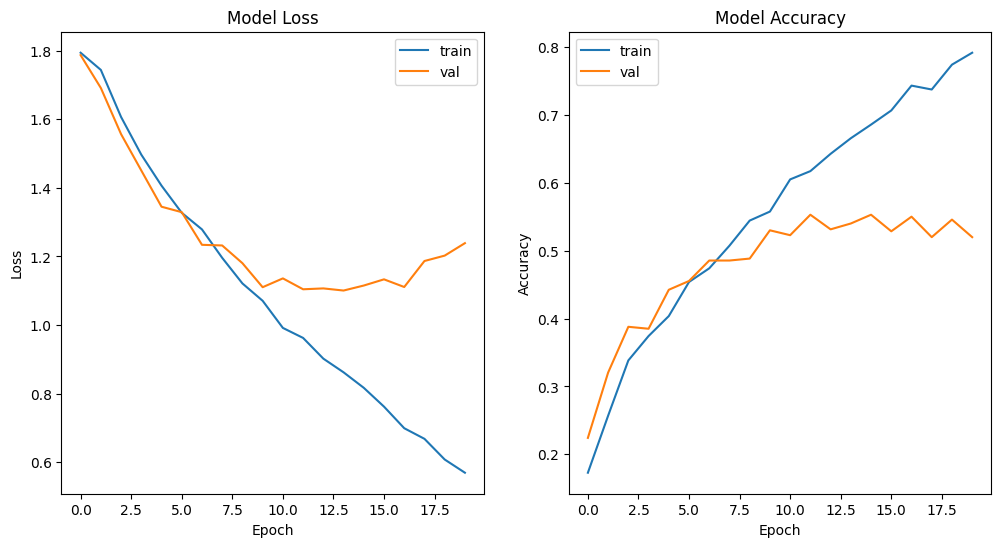

In [ ]:
loss_plot (history_hog_age)

## ORB

### Gender 

In [ ]:
orb_X_genders = []
for img in X_genders:
    img = img * 255.0
    orb_X_genders.append(img)

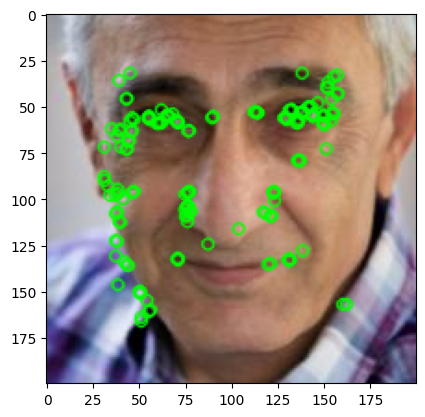

In [ ]:
image_check = orb_X_genders[1]
image_check = cv2.convertScaleAbs(image_check)
orb_X_genders = [cv2.convertScaleAbs(img) for img in orb_X_genders]

orb = cv2.ORB_create()

kp = orb.detect(image_check, None)

kp, des = orb.compute(image_check, kp)

img2 = cv2.drawKeypoints(image_check, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2)
plt.show()

In [ ]:
orb = cv2.ORB_create()
# define minimum and maximum keypoints
MIN_KEYPOINTS = 100
orb_features = []
orb_genders = []

# loop over images and keypoints
for i, img in enumerate(orb_X_genders):
    keypoints, descriptors = orb.detectAndCompute(img, None)
    keypoints, descriptors = orb.compute(image_check, keypoints)
    keypoints = list(keypoints)    
    # check if number of keypoints is between min and max
    if len(keypoints) < MIN_KEYPOINTS:
        continue
        
    # remove extra keypoints randomly
    while len(keypoints) > MIN_KEYPOINTS:
        idx = random.randint(0, len(keypoints)-1)
        keypoints.pop(idx)
        descriptors = np.delete(descriptors, idx, axis=0)
        
    # add descriptors to feature list
    orb_features.append(np.ndarray.flatten(descriptors))
    orb_genders.append(y_genders[i])
 
mean = np.mean(orb_features, axis=0)
std = np.std(orb_features, axis=0)
orb_features_norm = (orb_features - mean) / std

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(orb_features_norm, orb_genders, test_size=0.20, random_state=42)

In [ ]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [ ]:
cnn = Sequential()

# Input shape is (3200,)
cnn.add(layers.Reshape((50, 64, 1), input_shape=X_train[0].shape))

cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(Flatten())
cnn.add(layers.Dense(64, activation='relu'))

cnn.add(layers.Dropout(0.5))

cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 50, 64, 1)         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 50, 64, 16)        160       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 25, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 25, 32, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 12, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 12, 16, 64)       

In [ ]:
cnn.compile(optimizer="adam", loss="binary_crossentropy",
            metrics=['accuracy'])

history_orb_gender = cnn.fit(X_train, y_train,
                        epochs=20,
                        batch_size=32,
                        validation_data=(X_test, y_test))

Epoch 1/20
149/149 [==============================] - 3s 6ms/step - loss: 0.6986 - accuracy: 0.5078 - val_loss: 0.6920 - val_accuracy: 0.5496
Epoch 2/20
149/149 [==============================] - 1s 5ms/step - loss: 0.6897 - accuracy: 0.5389 - val_loss: 0.6798 - val_accuracy: 0.6000
Epoch 3/20
149/149 [==============================] - 1s 5ms/step - loss: 0.6658 - accuracy: 0.5986 - val_loss: 0.6388 - val_accuracy: 0.6345
Epoch 4/20
149/149 [==============================] - 1s 5ms/step - loss: 0.6430 - accuracy: 0.6369 - val_loss: 0.6247 - val_accuracy: 0.6689
Epoch 5/20
149/149 [==============================] - 1s 5ms/step - loss: 0.6247 - accuracy: 0.6537 - val_loss: 0.6271 - val_accuracy: 0.6664
Epoch 6/20
149/149 [==============================] - 1s 5ms/step - loss: 0.5972 - accuracy: 0.6899 - val_loss: 0.6156 - val_accuracy: 0.6546
Epoch 7/20
149/149 [==============================] - 1s 5ms/step - loss: 0.5710 - accuracy: 0.7044 - val_loss: 0.6277 - val_accuracy: 0.6504
Epoch 

38/38 [==============================] - 0s 2ms/step
MCC:  0.23102105873011847


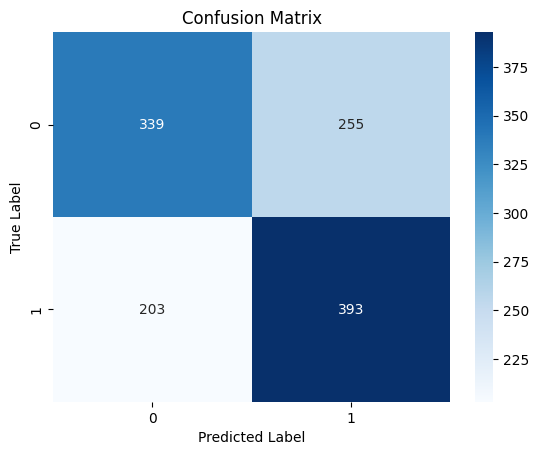

              precision    recall  f1-score   support

           0       0.63      0.57      0.60       594
           1       0.61      0.66      0.63       596

    accuracy                           0.62      1190
   macro avg       0.62      0.62      0.61      1190
weighted avg       0.62      0.62      0.61      1190



In [ ]:
prediction_metrics_gender(cnn, X_test, y_test, orb_genders)

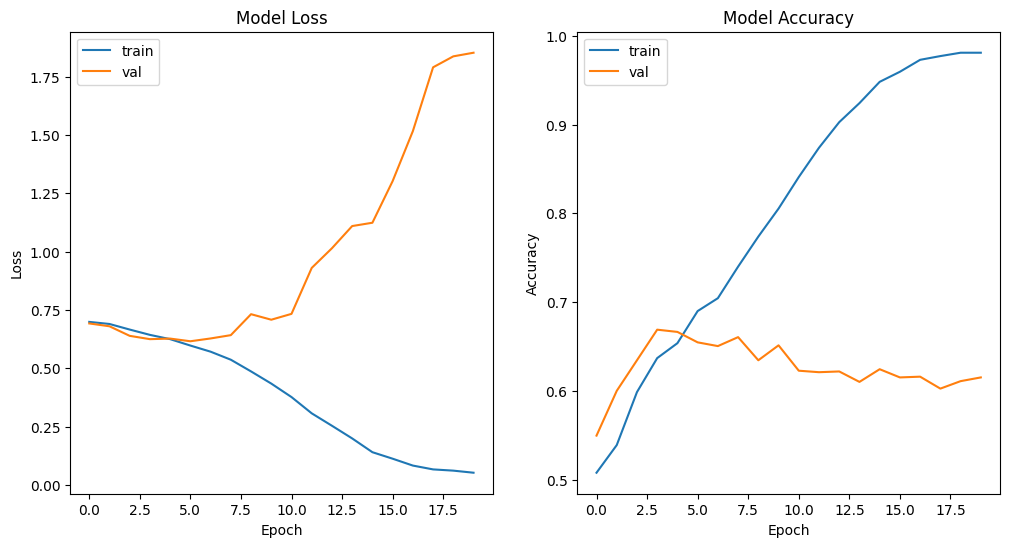

In [ ]:
loss_plot (history_orb_gender)

### Age

In [ ]:
orb_X_age_classes = []
for img in X_age_classes:
    img = img * 255.0
    orb_X_age_classes.append(img)

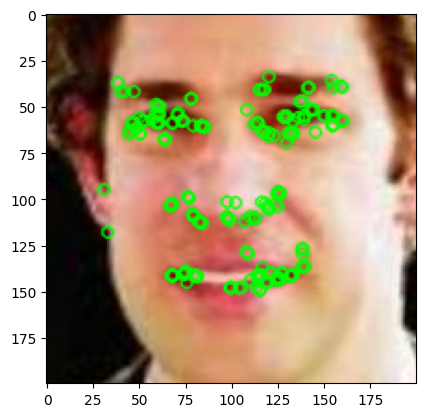

In [ ]:
image_check = orb_X_age_classes[1]
image_check = cv2.convertScaleAbs(image_check)
orb_X_age_classes = [cv2.convertScaleAbs(img) for img in orb_X_age_classes]

orb = cv2.ORB_create()

kp = orb.detect(image_check, None)

kp, des = orb.compute(image_check, kp)

img2 = cv2.drawKeypoints(image_check, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2)
plt.show()

In [ ]:
orb = cv2.ORB_create()
# define minimum and maximum keypoints
MIN_KEYPOINTS = 100
orb_features = []
#orb_genders = []
orb_ages = []

# loop over images and keypoints
for i, img in enumerate(orb_X_age_classes):
    keypoints, descriptors = orb.detectAndCompute(img, None)
    keypoints, descriptors = orb.compute(image_check, keypoints)
    keypoints = list(keypoints)    
    # check if number of keypoints is between min and max
    if len(keypoints) < MIN_KEYPOINTS:
        continue
        
    # remove extra keypoints randomly
    while len(keypoints) > MIN_KEYPOINTS:
        idx = random.randint(0, len(keypoints)-1)
        keypoints.pop(idx)
        descriptors = np.delete(descriptors, idx, axis=0)
        
    # add descriptors to feature list
    orb_features.append(np.ndarray.flatten(descriptors))
    #orb_genders.append(y_genders[i])
    orb_ages.append(age_categories[i])

mean = np.mean(orb_features, axis=0)
std = np.std(orb_features, axis=0)
orb_features_norm = (orb_features - mean) / std

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(orb_features_norm, orb_ages, test_size=0.20, random_state=42)

In [ ]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [ ]:
cnn = Sequential()

# Input shape is (3200,)
cnn.add(layers.Reshape((50, 64, 1), input_shape=X_train[0].shape))


cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(Flatten())

cnn.add(layers.Dense(64, activation='relu'))

cnn.add(layers.Dropout(0.5))

cnn.add(layers.Dense(6, activation='softmax'))

#cnn.summary()

In [ ]:
cnn.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_orb_age = cnn.fit(X_train, y_train,
                        epochs=20,
                        batch_size=32,
                        validation_data=(X_test, y_test))


Epoch 1/20
55/55 [==============================] - 2s 8ms/step - loss: 1.8059 - accuracy: 0.1802 - val_loss: 1.7882 - val_accuracy: 0.2009
Epoch 2/20
55/55 [==============================] - 0s 5ms/step - loss: 1.7912 - accuracy: 0.1865 - val_loss: 1.7902 - val_accuracy: 0.1553
Epoch 3/20
55/55 [==============================] - 0s 5ms/step - loss: 1.7892 - accuracy: 0.1905 - val_loss: 1.7886 - val_accuracy: 0.1553
Epoch 4/20
55/55 [==============================] - 0s 5ms/step - loss: 1.7869 - accuracy: 0.1922 - val_loss: 1.7881 - val_accuracy: 0.1553
Epoch 5/20
55/55 [==============================] - 0s 5ms/step - loss: 1.7843 - accuracy: 0.1796 - val_loss: 1.7865 - val_accuracy: 0.1553
Epoch 6/20
55/55 [==============================] - 0s 5ms/step - loss: 1.7796 - accuracy: 0.1957 - val_loss: 1.7818 - val_accuracy: 0.2443
Epoch 7/20
55/55 [==============================] - 0s 5ms/step - loss: 1.7683 - accuracy: 0.2031 - val_loss: 1.7492 - val_accuracy: 0.1963
Epoch 8/20
55/55 [==

14/14 [==============================] - 0s 2ms/step
MCC:  0.12814216455575733


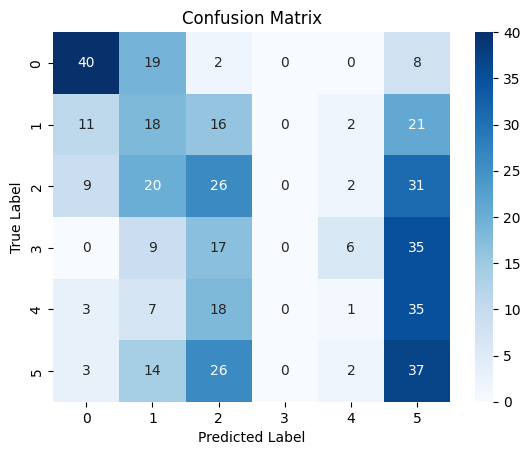

              precision    recall  f1-score   support

           0       0.61      0.58      0.59        69
           1       0.21      0.26      0.23        68
           2       0.25      0.30      0.27        88
           3       0.00      0.00      0.00        67
           4       0.08      0.02      0.03        64
           5       0.22      0.45      0.30        82

    accuracy                           0.28       438
   macro avg       0.23      0.27      0.24       438
weighted avg       0.23      0.28      0.24       438



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
prediction_metrics_age(cnn, X_test, y_test, y_age_classes)

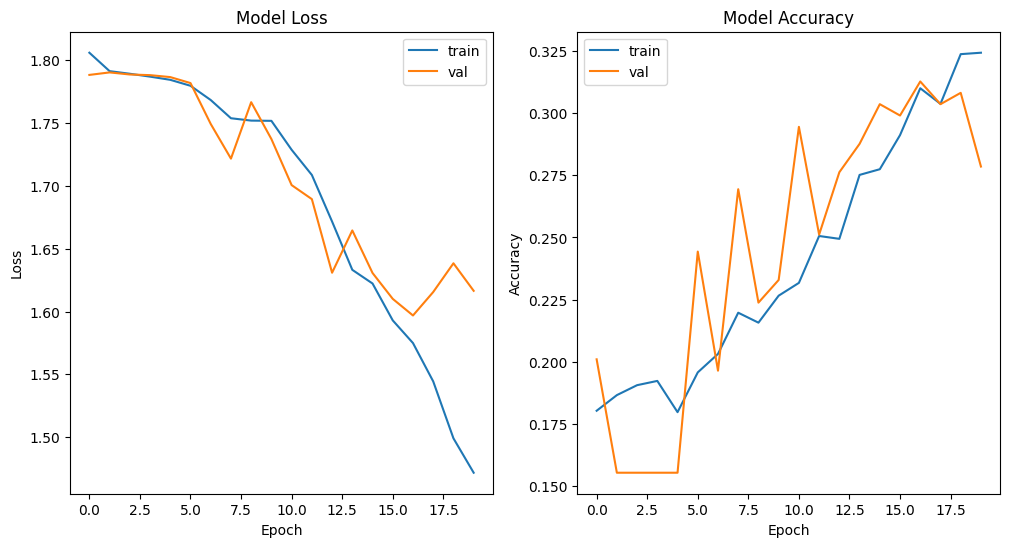

In [ ]:
loss_plot (history_orb_age)

## VGG 16

### Gender

In [ ]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

for layer in VGG_model.layers:
	layer.trainable = False
	
X = np.stack(X_genders)
X = VGG_model.predict(X)

313/313 [==============================] - 6s 18ms/step


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_genders, test_size=0.2, random_state=42)

In [ ]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [ ]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape = (6, 6, 512))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))



model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))


model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))


model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(64, activation='relu'))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 6, 6, 16)          73744     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 3, 3, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 1, 1, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 1, 1, 64)          18496     
                                                                 
 flatten_6 (Flatten)         (None, 64)               

In [ ]:
#for age use categorical_crossentropy instead
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

history_VGG16_gender = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/20
250/250 [==============================] - 4s 6ms/step - loss: 0.4782 - accuracy: 0.7648 - val_loss: 0.3181 - val_accuracy: 0.8665
Epoch 2/20
250/250 [==============================] - 1s 5ms/step - loss: 0.3248 - accuracy: 0.8648 - val_loss: 0.2799 - val_accuracy: 0.8830
Epoch 3/20
250/250 [==============================] - 1s 5ms/step - loss: 0.2682 - accuracy: 0.8913 - val_loss: 0.2682 - val_accuracy: 0.8830
Epoch 4/20
250/250 [==============================] - 1s 5ms/step - loss: 0.2258 - accuracy: 0.9151 - val_loss: 0.3055 - val_accuracy: 0.8820
Epoch 5/20
250/250 [==============================] - 1s 5ms/step - loss: 0.2013 - accuracy: 0.9226 - val_loss: 0.2862 - val_accuracy: 0.8870
Epoch 6/20
250/250 [==============================] - 1s 5ms/step - loss: 0.1731 - accuracy: 0.9358 - val_loss: 0.2996 - val_accuracy: 0.8845
Epoch 7/20
250/250 [==============================] - 1s 5ms/step - loss: 0.1436 - accuracy: 0.9489 - val_loss: 0.3171 - val_accuracy: 0.8810
Epoch 

63/63 [==============================] - 0s 2ms/step
MCC:  0.7566430089607977


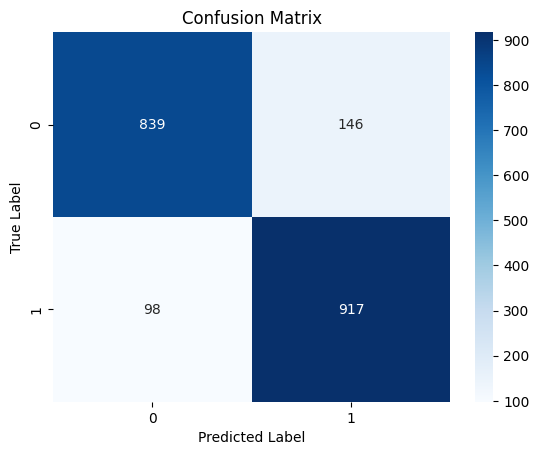

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       985
           1       0.86      0.90      0.88      1015

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



In [ ]:
prediction_metrics_gender(model, X_test, y_test, y_genders)

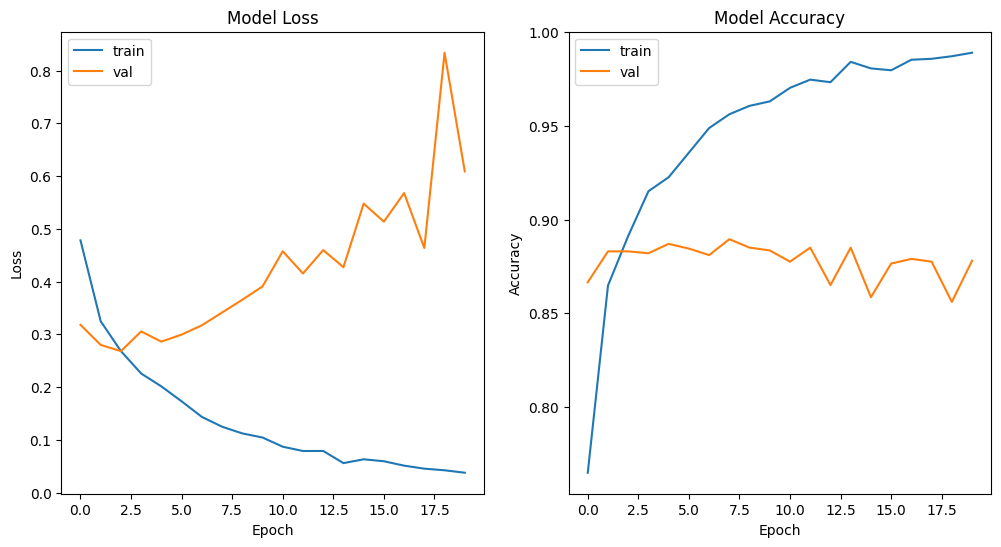

In [ ]:
loss_plot (history_VGG16_gender)

### Age

In [ ]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

for layer in VGG_model.layers:
	layer.trainable = False
	
X = np.stack(X_age_classes)
X = VGG_model.predict(X)

109/109 [==============================] - 2s 16ms/step


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, age_categories, test_size=0.2, random_state=42)

In [ ]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape = (6, 6, 512))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))



model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))


model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))


model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(64, activation='relu'))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 6, 6, 16)          73744     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 3, 3, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 1, 1, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 1, 1, 64)          18496     
                                                                 
 flatten_12 (Flatten)        (None, 64)              

In [ ]:
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_VGG16_age = model.fit(X_train, y_train,
        batch_size=32,
        epochs=20,
        validation_data=(X_test, y_test),)

Epoch 1/20
87/87 [==============================] - 3s 8ms/step - loss: 1.6010 - accuracy: 0.3330 - val_loss: 1.2858 - val_accuracy: 0.4943
Epoch 2/20
87/87 [==============================] - 0s 5ms/step - loss: 1.2314 - accuracy: 0.4781 - val_loss: 1.0939 - val_accuracy: 0.5201
Epoch 3/20
87/87 [==============================] - 0s 5ms/step - loss: 1.1026 - accuracy: 0.5474 - val_loss: 1.0238 - val_accuracy: 0.5618
Epoch 4/20
87/87 [==============================] - 0s 5ms/step - loss: 1.0084 - accuracy: 0.5711 - val_loss: 0.9482 - val_accuracy: 0.6020
Epoch 5/20
87/87 [==============================] - 0s 5ms/step - loss: 0.9315 - accuracy: 0.6250 - val_loss: 0.9347 - val_accuracy: 0.6121
Epoch 6/20
87/87 [==============================] - 0s 5ms/step - loss: 0.8571 - accuracy: 0.6491 - val_loss: 0.9288 - val_accuracy: 0.6236
Epoch 7/20
87/87 [==============================] - 0s 5ms/step - loss: 0.8057 - accuracy: 0.6760 - val_loss: 0.9513 - val_accuracy: 0.5963
Epoch 8/20
87/87 [==

22/22 [==============================] - 0s 3ms/step
MCC:  0.020430858218993448


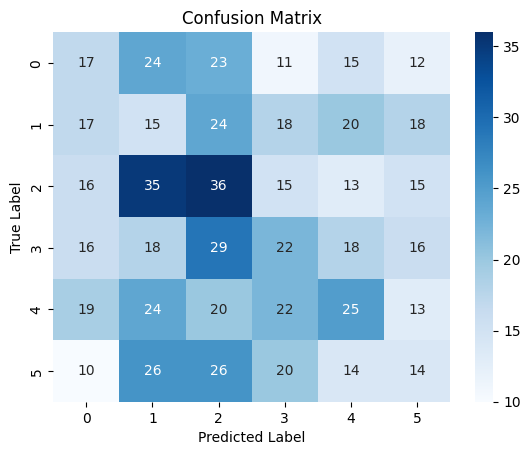

              precision    recall  f1-score   support

           0       0.18      0.17      0.17       102
           1       0.11      0.13      0.12       112
           2       0.23      0.28      0.25       130
           3       0.20      0.18      0.19       119
           4       0.24      0.20      0.22       123
           5       0.16      0.13      0.14       110

    accuracy                           0.19       696
   macro avg       0.19      0.18      0.18       696
weighted avg       0.19      0.19      0.19       696



In [ ]:
prediction_metrics_age(model, X_test, y_train, y_age_classes)

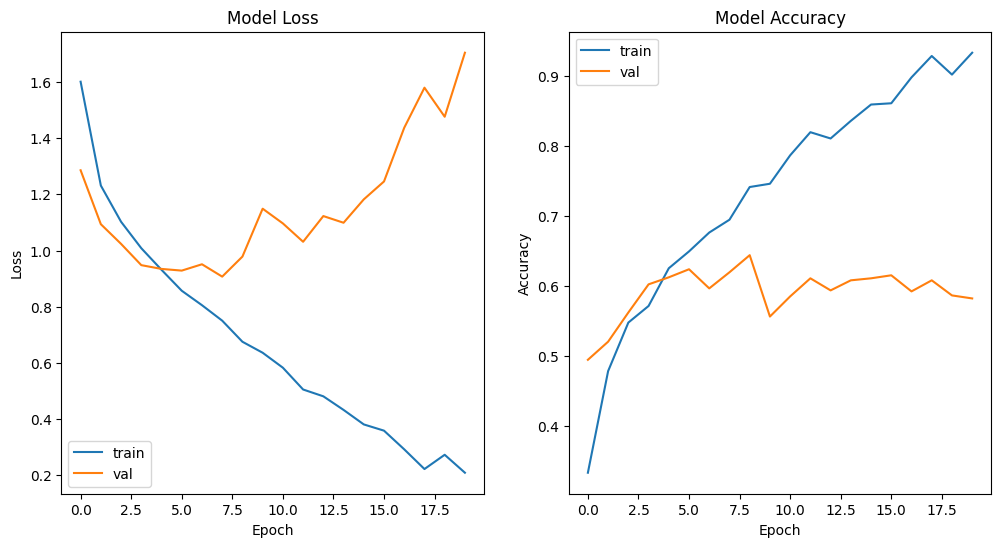

In [ ]:
loss_plot (history_VGG16_age)

## Autoencoder

### Gender

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_genders, y_genders, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 3))

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 3))

In [ ]:
# binary cross entropy is good for imagprint("Autoencoder Started")
#### AUtoencoder
input = layers.Input(shape=(200, 200, 3))

#valor alto apanha artefactos, e valor baixo nao captura bem as features da imagem
latent_dim = 2000

## Classe 

# Encoder

#didnt increase filter count in encoder and decrease equally in decoder because
#it can lead to overfitting

x = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides = 2)(input)
#x = layers.MaxPooling2D((2,2), padding='same')(x)#dividir imagem por factor de 2
x = layers.Conv2D(32, (3,3), activation='relu', padding='same', strides = 2)(x)#reduziu se nr de filtros para 32 porque foi decidido factor de 32 filtros
#x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)
#x = layers.MaxPooling2D((2,2), padding='same')(x)#25*25*16=10000
x = layers.Flatten()(x)
enc = layers.Dense(latent_dim, activation='relu')(x)

# Decoder

#having conv2D here helps to avoid checkerboard artifacts
#which are alternating points of colors (like checkerboard)
#that are consequence of deconvolutioning an image and cause 
#loss of quality in final reconstruction
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)

#equivalente a fazer dense layer no fim do encoder e no inicio do decoder
#fazer a layer dense fica um vector
#fazer reshape depois do 2 dense para voltar a ter imagem do vetor criado

x = layers.Dense(25*25*16, activation='relu')(enc)
x = layers.Reshape((25,25,16))(x)
#x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same", strides = 2)(x)
#x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides = 2)(x)
#x = layers.UpSampling2D((2,2))(x)
output = layers.Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same', strides = 2)(x)

#maybe use strides in the layers too
#example:
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)

# Autoencoder
autoencoder = Model(input, output)

# binary cross entropy is good for image feature extraction especially when images are normalized
autoencoder.compile(optimizer="adam", loss="binary_crossentropy",
            metrics=['accuracy'])

autoencoder.summary()#e feature extraction especially when images are normalized


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_29 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 conv2d_30 (Conv2D)          (None, 50, 50, 32)        18464     
                                                                 
 conv2d_31 (Conv2D)          (None, 25, 25, 16)        4624      
                                                                 
 flatten_10 (Flatten)        (None, 10000)             0         
                                                                 
 dense_20 (Dense)            (None, 2000)              20002000  
                                                                 
 dense_21 (Dense)            (None, 10000)             200100

In [ ]:
#using validation_data is good for detecting overfitting as 
#it does early stopping when the performance is no longer improving

autoencoder.fit(x = X_train, 
                y = X_train,
                epochs = 20,
                shuffle = True,
                batch_size = 32,
                validation_data = (X_test, X_test),)

Epoch 1/20
250/250 [==============================] - 11s 29ms/step - loss: 0.6107 - accuracy: 0.9198 - val_loss: 0.5769 - val_accuracy: 0.9300
Epoch 2/20
250/250 [==============================] - 5s 21ms/step - loss: 0.5694 - accuracy: 0.9238 - val_loss: 0.5679 - val_accuracy: 0.9262
Epoch 3/20
250/250 [==============================] - 5s 21ms/step - loss: 0.5627 - accuracy: 0.9207 - val_loss: 0.5636 - val_accuracy: 0.9211
Epoch 4/20
250/250 [==============================] - 5s 21ms/step - loss: 0.5595 - accuracy: 0.9198 - val_loss: 0.5626 - val_accuracy: 0.9240
Epoch 5/20
250/250 [==============================] - 5s 21ms/step - loss: 0.5574 - accuracy: 0.9205 - val_loss: 0.5598 - val_accuracy: 0.9287
Epoch 6/20
250/250 [==============================] - 5s 21ms/step - loss: 0.5559 - accuracy: 0.9217 - val_loss: 0.5591 - val_accuracy: 0.9234
Epoch 7/20
250/250 [==============================] - 5s 21ms/step - loss: 0.5550 - accuracy: 0.9234 - val_loss: 0.5578 - val_accuracy: 0.923

In [ ]:
new_model = Model(input, enc)

encoded_train = new_model.predict(X_train)
encoded_test = new_model.predict(X_test)

encoded_train = np.asarray(encoded_train)
y_train = np.asarray(y_train)

encoded_test = np.asarray(encoded_test)
y_test = np.asarray(y_test)

63/63 [==============================] - 0s 5ms/step


In [ ]:
cnn = Sequential()

# Input shape is (2000,)
cnn.add(layers.Reshape((40, 50, 1), input_shape=encoded_train[0].shape))

cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(Flatten())

cnn.add(Dense(64, activation='relu'))

cnn.add(layers.Dropout(0.5))

#output layer with 2 filters for number of classes the model will choose to do predictions
#and since gender is just binary classification sigmoid is appropriate
#when doing classification for age (wont be binary classification) then softmax is good choice
cnn.add(Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 40, 50, 1)         0         
                                                                 
 conv2d_32 (Conv2D)          (None, 40, 50, 16)        160       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 20, 25, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 20, 25, 32)        4640      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 10, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 10, 12, 64)      

In [ ]:
#for age use categorical_crossentropy instead
cnn.compile(optimizer="adam", loss="binary_crossentropy",
            metrics=['accuracy'])

history_autoencoder_gender = cnn.fit(encoded_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(encoded_test, y_test))

Epoch 1/20
250/250 [==============================] - 4s 6ms/step - loss: 0.5818 - accuracy: 0.6840 - val_loss: 0.4233 - val_accuracy: 0.8230
Epoch 2/20
250/250 [==============================] - 1s 4ms/step - loss: 0.4119 - accuracy: 0.8223 - val_loss: 0.3611 - val_accuracy: 0.8420
Epoch 3/20
250/250 [==============================] - 1s 4ms/step - loss: 0.3532 - accuracy: 0.8511 - val_loss: 0.3509 - val_accuracy: 0.8485
Epoch 4/20
250/250 [==============================] - 1s 5ms/step - loss: 0.3114 - accuracy: 0.8679 - val_loss: 0.3387 - val_accuracy: 0.8505
Epoch 5/20
250/250 [==============================] - 1s 4ms/step - loss: 0.2865 - accuracy: 0.8857 - val_loss: 0.3790 - val_accuracy: 0.8280
Epoch 6/20
250/250 [==============================] - 1s 4ms/step - loss: 0.2579 - accuracy: 0.8990 - val_loss: 0.3283 - val_accuracy: 0.8565
Epoch 7/20
250/250 [==============================] - 1s 4ms/step - loss: 0.2302 - accuracy: 0.9078 - val_loss: 0.3353 - val_accuracy: 0.8585
Epoch 

63/63 [==============================] - 0s 2ms/step
MCC:  0.6802581907314481


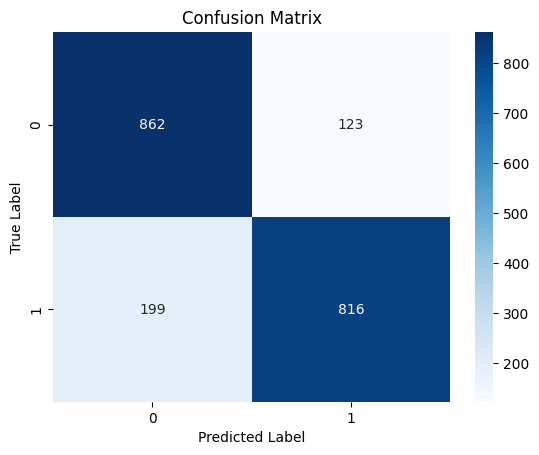

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       985
           1       0.87      0.80      0.84      1015

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



In [ ]:
prediction_metrics_gender(cnn, encoded_test, y_test, y_genders)

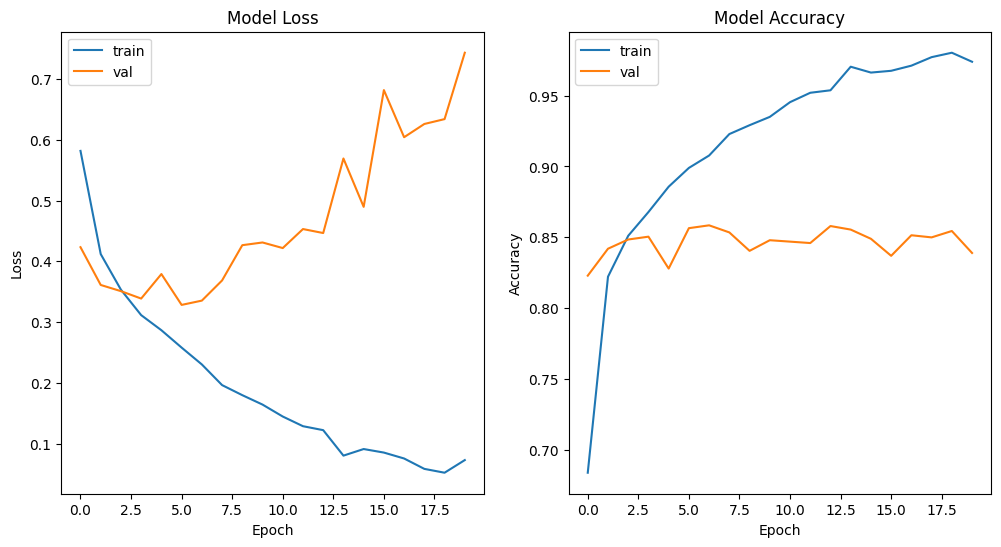

In [ ]:
loss_plot (history_autoencoder_gender)

### Age

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_age_classes, age_categories, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 3))

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 3))

In [ ]:
# binary cross entropy is good for imagprint("Autoencoder Started")
#### AUtoencoder
input = layers.Input(shape=(200, 200, 3))

#valor alto apanha artefactos, e valor baixo nao captura bem as features da imagem
latent_dim = 2000

## Classe 

# Encoder

#didnt increase filter count in encoder and decrease equally in decoder because
#it can lead to overfitting

x = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides = 2)(input)
#x = layers.MaxPooling2D((2,2), padding='same')(x)#dividir imagem por factor de 2
x = layers.Conv2D(32, (3,3), activation='relu', padding='same', strides = 2)(x)#reduziu se nr de filtros para 32 porque foi decidido factor de 32 filtros
#x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)
#x = layers.MaxPooling2D((2,2), padding='same')(x)#25*25*16=10000
x = layers.Flatten()(x)
enc = layers.Dense(latent_dim, activation='relu')(x)

# Decoder

#having conv2D here helps to avoid checkerboard artifacts
#which are alternating points of colors (like checkerboard)
#that are consequence of deconvolutioning an image and cause 
#loss of quality in final reconstruction
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)

#equivalente a fazer dense layer no fim do encoder e no inicio do decoder
#fazer a layer dense fica um vector
#fazer reshape depois do 2 dense para voltar a ter imagem do vetor criado

x = layers.Dense(25*25*16, activation='relu')(enc)
x = layers.Reshape((25,25,16))(x)
#x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same", strides = 2)(x)
#x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides = 2)(x)
#x = layers.UpSampling2D((2,2))(x)
output = layers.Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same', strides = 2)(x)

#maybe use strides in the layers too
#example:
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)

# Autoencoder
autoencoder = Model(input, output)

# binary cross entropy is good for image feature extraction especially when images are normalized
autoencoder.compile(optimizer="adam", loss="binary_crossentropy",
            metrics=['accuracy'])

autoencoder.summary()#e feature extraction especially when images are normalized

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 64)      1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 32)        18464     
                                                                 
 conv2d_8 (Conv2D)           (None, 25, 25, 16)        4624      
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_4 (Dense)             (None, 2000)              20002000  
                                                                 
 dense_5 (Dense)             (None, 10000)             2001

In [ ]:
autoencoder.fit(x = X_train, 
                y = X_train,
                epochs = 20,
                shuffle = True,
                batch_size = 32,
                validation_data = (X_test, X_test),)


Epoch 1/20
87/87 [==============================] - 6s 31ms/step - loss: 0.6589 - accuracy: 0.9140 - val_loss: 0.6315 - val_accuracy: 0.9297
Epoch 2/20
87/87 [==============================] - 2s 21ms/step - loss: 0.6049 - accuracy: 0.9262 - val_loss: 0.5890 - val_accuracy: 0.9296
Epoch 3/20
87/87 [==============================] - 2s 21ms/step - loss: 0.5825 - accuracy: 0.9259 - val_loss: 0.5786 - val_accuracy: 0.9293
Epoch 4/20
87/87 [==============================] - 2s 21ms/step - loss: 0.5750 - accuracy: 0.9256 - val_loss: 0.5739 - val_accuracy: 0.9292
Epoch 5/20
87/87 [==============================] - 2s 21ms/step - loss: 0.5707 - accuracy: 0.9253 - val_loss: 0.5709 - val_accuracy: 0.9290
Epoch 6/20
87/87 [==============================] - 2s 21ms/step - loss: 0.5684 - accuracy: 0.9250 - val_loss: 0.5685 - val_accuracy: 0.9277
Epoch 7/20
87/87 [==============================] - 2s 21ms/step - loss: 0.5659 - accuracy: 0.9247 - val_loss: 0.5670 - val_accuracy: 0.9284
Epoch 8/20
87

In [ ]:
new_model = Model(input, enc)
encoded_train = new_model.predict(X_train)
encoded_test = new_model.predict(X_test)

encoded_train = np.asarray(encoded_train)
y_train = np.asarray(y_train)

encoded_test = np.asarray(encoded_test)
y_test = np.asarray(y_test)

22/22 [==============================] - 0s 5ms/step


In [ ]:
cnn = Sequential()

# Input shape is (2000,)
cnn.add(layers.Reshape((40, 50, 1), input_shape=encoded_train[0].shape))

cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(Flatten())

cnn.add(Dense(64, activation='relu'))

cnn.add(layers.Dropout(0.5))

#output layer with 2 filters for number of classes the model will choose to do predictions
#and since gender is just binary classification sigmoid is appropriate
#when doing classification for age (wont be binary classification) then softmax is good choice
cnn.add(layers.Dense(6, activation='softmax'))

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 40, 50, 1)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 50, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 20, 25, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 25, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 10, 12, 64)       

In [ ]:
cnn.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_autoencoder_age = cnn.fit(encoded_train, y_train,
        batch_size=32,
        epochs=20,
        validation_data=(encoded_test, y_test),)

Epoch 1/20
87/87 [==============================] - 3s 6ms/step - loss: 1.7874 - accuracy: 0.1810 - val_loss: 1.7530 - val_accuracy: 0.2557
Epoch 2/20
87/87 [==============================] - 0s 4ms/step - loss: 1.7001 - accuracy: 0.2690 - val_loss: 1.6038 - val_accuracy: 0.2845
Epoch 3/20
87/87 [==============================] - 0s 4ms/step - loss: 1.5433 - accuracy: 0.3409 - val_loss: 1.5106 - val_accuracy: 0.3894
Epoch 4/20
87/87 [==============================] - 0s 4ms/step - loss: 1.3888 - accuracy: 0.4142 - val_loss: 1.3211 - val_accuracy: 0.4799
Epoch 5/20
87/87 [==============================] - 0s 4ms/step - loss: 1.3048 - accuracy: 0.4540 - val_loss: 1.2341 - val_accuracy: 0.4871
Epoch 6/20
87/87 [==============================] - 0s 4ms/step - loss: 1.2171 - accuracy: 0.4881 - val_loss: 1.2229 - val_accuracy: 0.5000
Epoch 7/20
87/87 [==============================] - 0s 4ms/step - loss: 1.1474 - accuracy: 0.5122 - val_loss: 1.1631 - val_accuracy: 0.5259
Epoch 8/20
87/87 [==

22/22 [==============================] - 0s 2ms/step
MCC:  0.4110025725776332


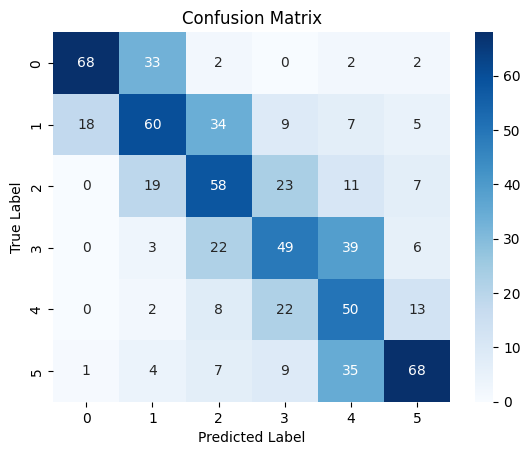

              precision    recall  f1-score   support

           0       0.78      0.64      0.70       107
           1       0.50      0.45      0.47       133
           2       0.44      0.49      0.47       118
           3       0.44      0.41      0.42       119
           4       0.35      0.53      0.42        95
           5       0.67      0.55      0.60       124

    accuracy                           0.51       696
   macro avg       0.53      0.51      0.51       696
weighted avg       0.53      0.51      0.51       696



In [ ]:
prediction_metrics_age(cnn, encoded_test, y_test, y_age_classes)

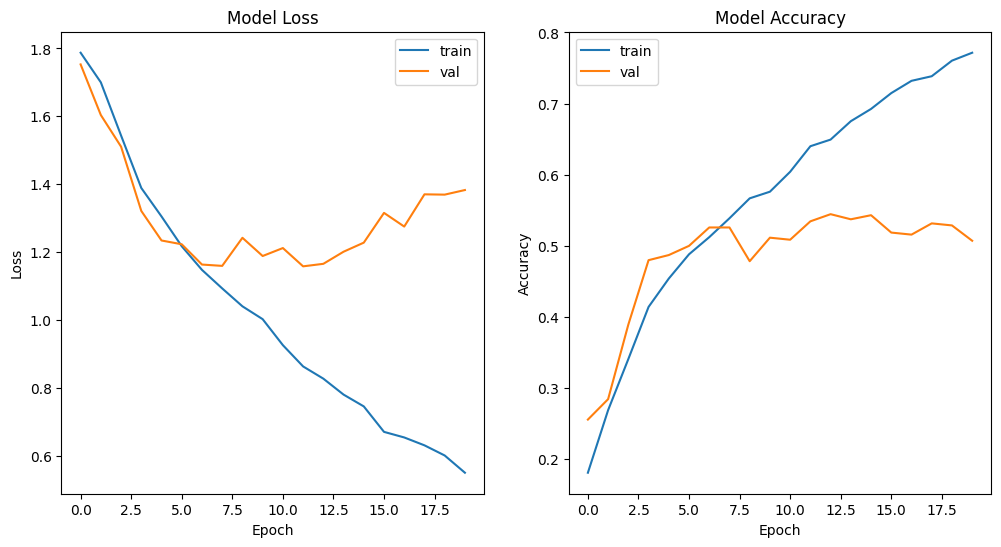

In [ ]:
loss_plot (history_autoencoder_age)

## Improved CNN

In [9]:
def CNN (input_shape, output, activation):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape)) 
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(output, activation=activation))

    return model

    model.summary()


### Age Classes

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_age_classes, age_categories, test_size = 0.2, random_state=42)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

22/22 [==============================] - 0s 13ms/step - loss: 0.8861 - accuracy: 0.6250
Test loss with <keras.optimizers.adam.Adam object at 0x7fade9f074f0>: 0.8860889077186584
Test accuracy with <keras.optimizers.adam.Adam object at 0x7fade9f074f0>: 0.625
22/22 [==============================] - 0s 10ms/step
MCC:  0.5503554955927816


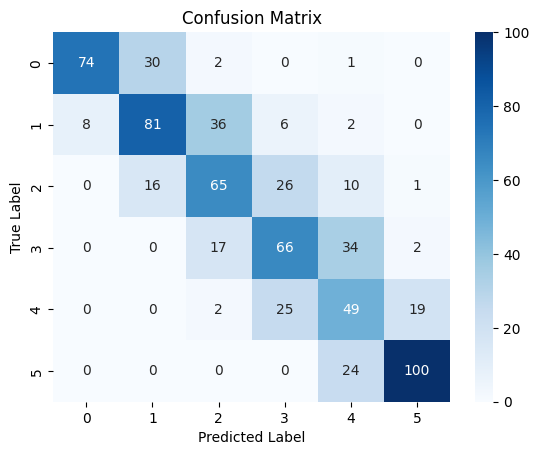

              precision    recall  f1-score   support

           0       0.90      0.69      0.78       107
           1       0.64      0.61      0.62       133
           2       0.53      0.55      0.54       118
           3       0.54      0.55      0.55       119
           4       0.41      0.52      0.46        95
           5       0.82      0.81      0.81       124

    accuracy                           0.62       696
   macro avg       0.64      0.62      0.63       696
weighted avg       0.64      0.62      0.63       696



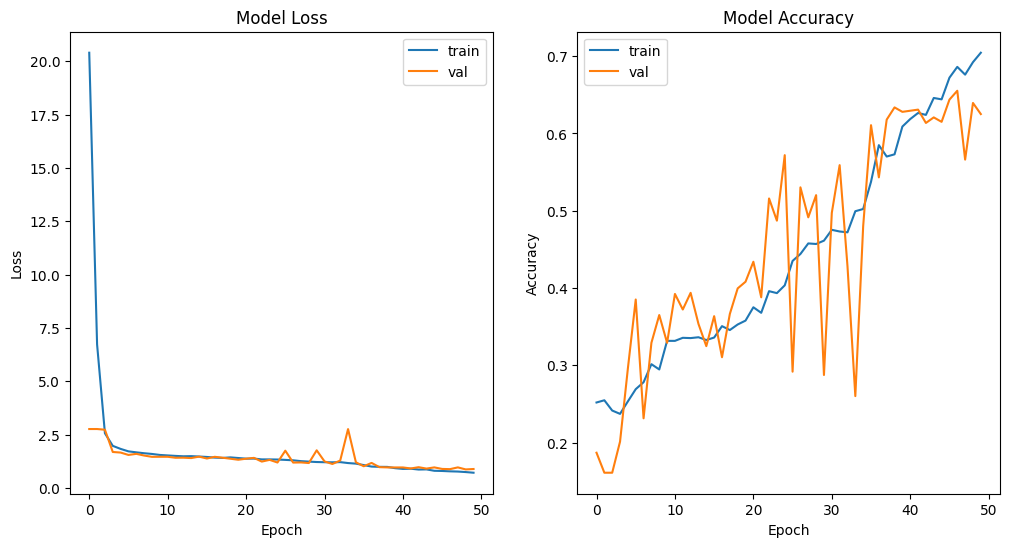

22/22 [==============================] - 0s 12ms/step - loss: 0.9289 - accuracy: 0.6509
Test loss with <keras.optimizers.sgd.SGD object at 0x7fade9f061a0>: 0.9289349913597107
Test accuracy with <keras.optimizers.sgd.SGD object at 0x7fade9f061a0>: 0.6508620977401733
22/22 [==============================] - 0s 10ms/step
MCC:  0.581389072988949


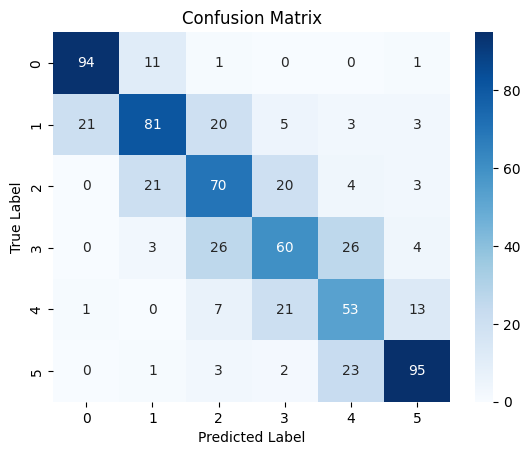

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       107
           1       0.69      0.61      0.65       133
           2       0.55      0.59      0.57       118
           3       0.56      0.50      0.53       119
           4       0.49      0.56      0.52        95
           5       0.80      0.77      0.78       124

    accuracy                           0.65       696
   macro avg       0.65      0.65      0.65       696
weighted avg       0.65      0.65      0.65       696



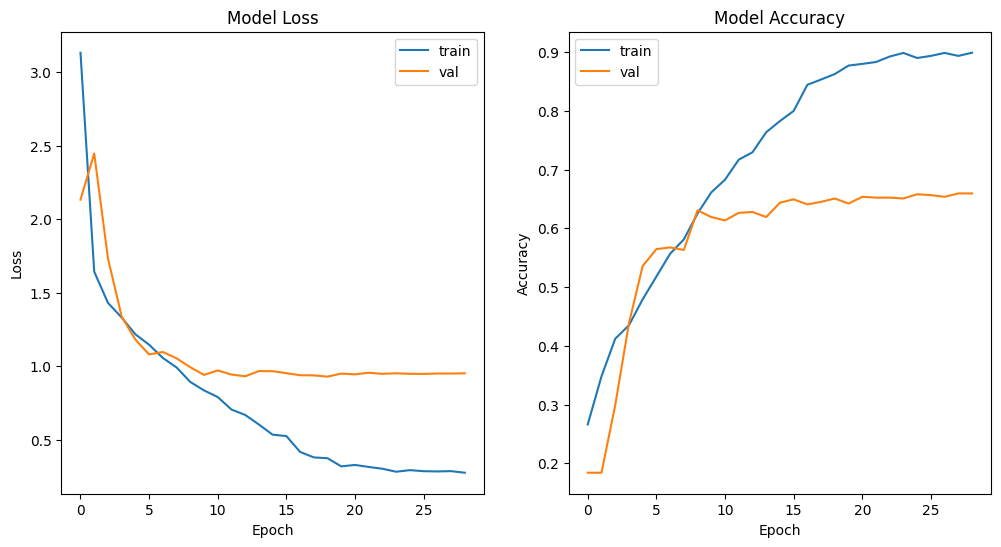

22/22 [==============================] - 0s 13ms/step - loss: 0.9796 - accuracy: 0.5948
Test loss with <keras.optimizers.rmsprop.RMSprop object at 0x7fadeb909240>: 0.979586660861969
Test accuracy with <keras.optimizers.rmsprop.RMSprop object at 0x7fadeb909240>: 0.5948275923728943
22/22 [==============================] - 0s 11ms/step
MCC:  0.518785915872149


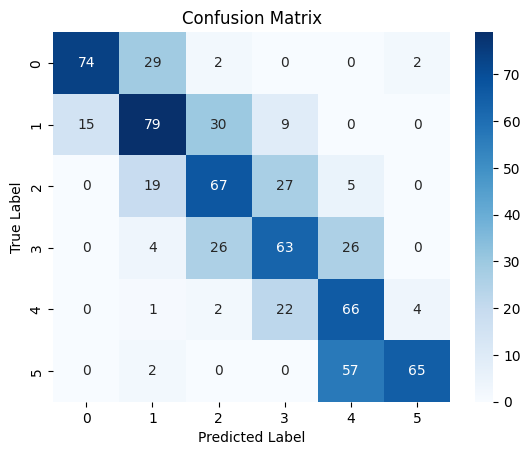

              precision    recall  f1-score   support

           0       0.83      0.69      0.76       107
           1       0.59      0.59      0.59       133
           2       0.53      0.57      0.55       118
           3       0.52      0.53      0.53       119
           4       0.43      0.69      0.53        95
           5       0.92      0.52      0.67       124

    accuracy                           0.59       696
   macro avg       0.64      0.60      0.60       696
weighted avg       0.64      0.59      0.60       696



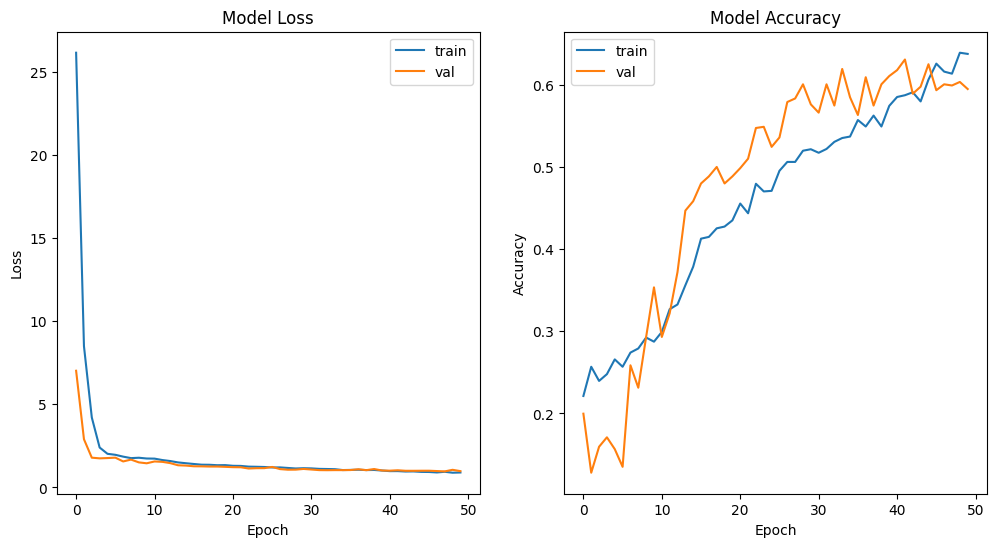

In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

optimizers = [Adam(), SGD(), RMSprop()]

for optimizer in optimizers:
    # build and compile the model
    model = CNN((200,200,3), 6, 'softmax')
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # train the model and evaluate its performance
    history_improved_age = model.fit(X_train, y_train,
        batch_size=32,
        epochs=50,
        validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr], verbose = False)
    loss, accuracy = model.evaluate(X_test, y_test)
    
    print(f'Test loss with {optimizer}: {loss}')
    print(f'Test accuracy with {optimizer}: {accuracy}')
    prediction_metrics_age(model, X_test, y_test, y_age_classes)
    loss_plot(history_improved_age)

### Genders

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_genders, y_genders, test_size=0.2, random_state=42)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

125/125 [==============================] - 2s 12ms/step - loss: 0.2597 - accuracy: 0.9035
Test loss with <keras.optimizers.adam.Adam object at 0x7f35e264aef0>: 0.2596606910228729
Test accuracy with <keras.optimizers.adam.Adam object at 0x7f35e264aef0>: 0.9035000205039978
125/125 [==============================] - 2s 10ms/step
MCC:  0.809389971662355


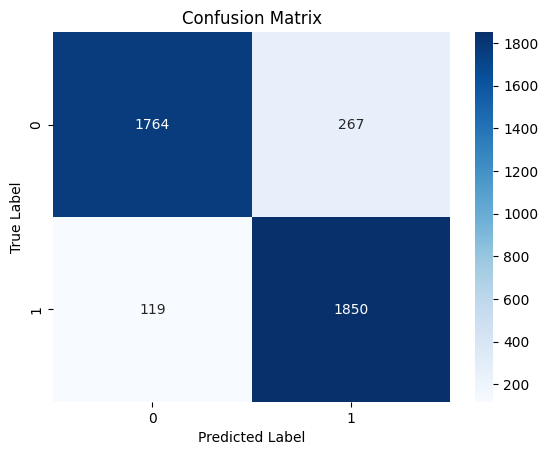

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      2031
           1       0.87      0.94      0.91      1969

    accuracy                           0.90      4000
   macro avg       0.91      0.90      0.90      4000
weighted avg       0.91      0.90      0.90      4000



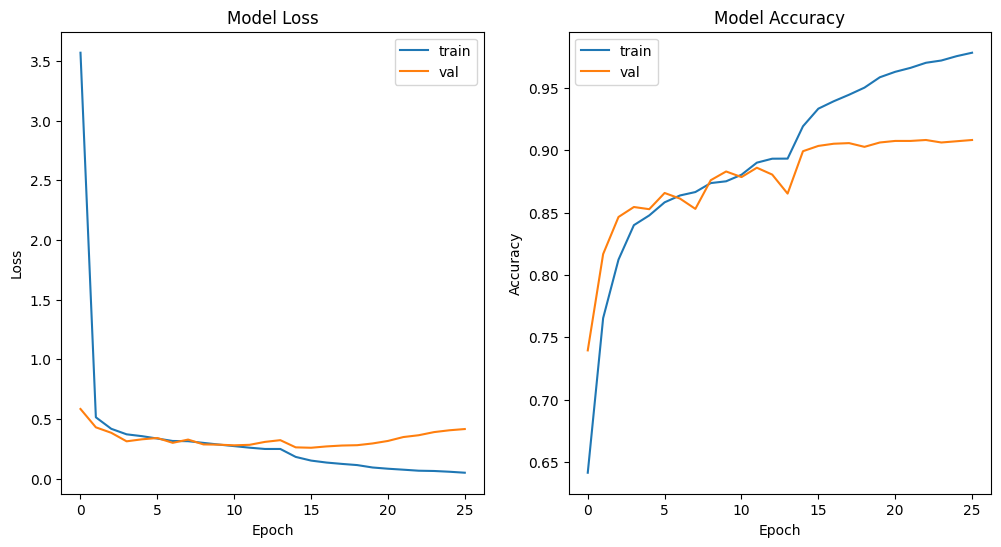

125/125 [==============================] - 2s 12ms/step - loss: 0.2444 - accuracy: 0.8955
Test loss with <keras.optimizers.sgd.SGD object at 0x7f35e2649c30>: 0.24439582228660583
Test accuracy with <keras.optimizers.sgd.SGD object at 0x7f35e2649c30>: 0.8955000042915344
125/125 [==============================] - 2s 11ms/step
MCC:  0.7917124800008549


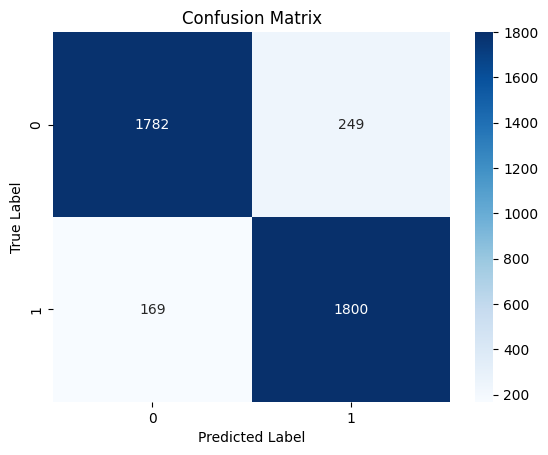

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      2031
           1       0.88      0.91      0.90      1969

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



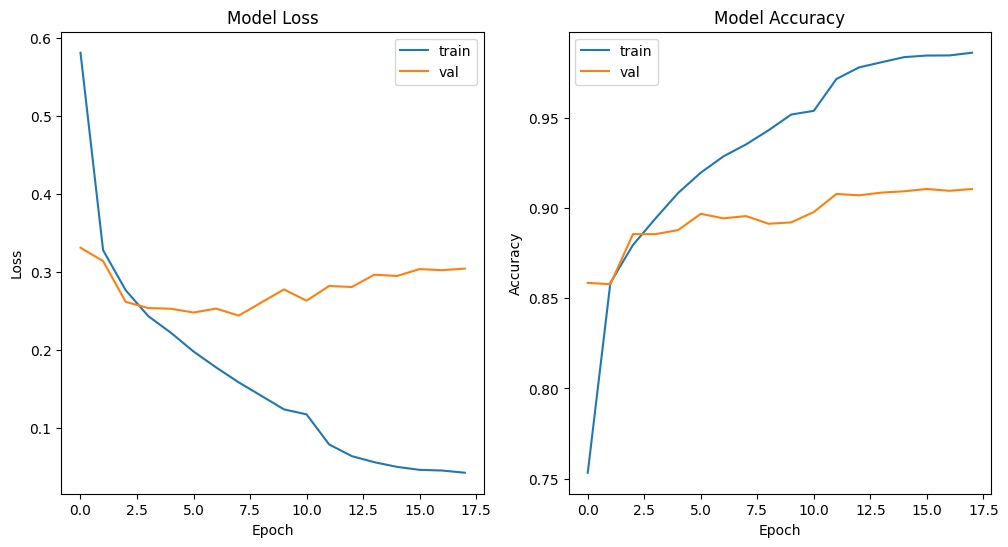

125/125 [==============================] - 2s 12ms/step - loss: 0.2977 - accuracy: 0.8930
Test loss with <keras.optimizers.rmsprop.RMSprop object at 0x7f353105da80>: 0.2977103292942047
Test accuracy with <keras.optimizers.rmsprop.RMSprop object at 0x7f353105da80>: 0.8930000066757202
125/125 [==============================] - 1s 10ms/step
MCC:  0.7874647649610345


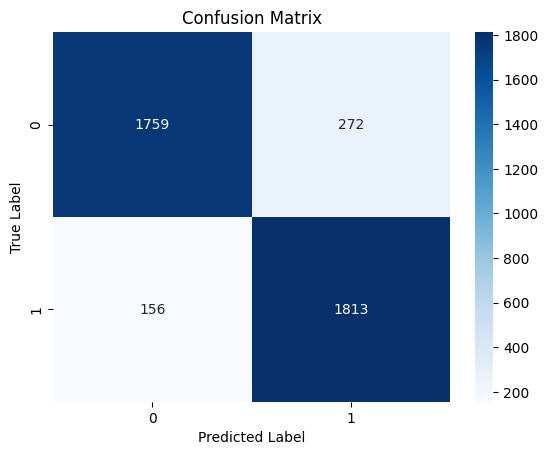

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      2031
           1       0.87      0.92      0.89      1969

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



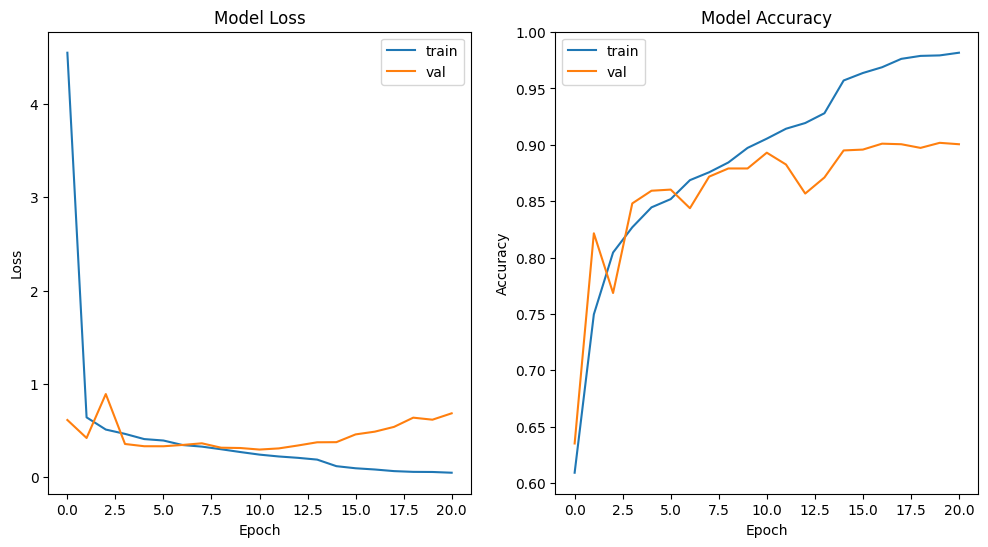

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

optimizers = [Adam(), SGD(), RMSprop()]

for optimizer in optimizers:
    # build and compile the model
    model = CNN((200,200,3), 1, 'sigmoid')
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # train the model and evaluate its performance
    history_improved_gender = model.fit(X_train, y_train,
        batch_size=32,
        epochs=50,
        validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr], verbose = False)
    loss, accuracy = model.evaluate(X_test, y_test)
    
    print(f'Test loss with {optimizer}: {loss}')
    print(f'Test accuracy with {optimizer}: {accuracy}')
    prediction_metrics_gender(model, X_test, y_test, y_genders)
    loss_plot(history_improved_gender)